<a href="https://colab.research.google.com/github/Xavi990/ML_hotel_bookings/blob/master/Tp01_Arboles_ver01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cargar archivo CSV 

from google.colab import files

uploaded=files.upload()

Saving hotel_bookings_preprocessed_dup.csv to hotel_bookings_preprocessed_dup.csv


In [16]:
# abrimos el archivo prepocesado que contiene solo los atributos que vamos a usar en el arbol
import io
import pandas as pd

df_booking = pd.read_csv('/content/drive/My Drive/Maestria_DataMining/Aprendizaje Automatico (Lunes)/TP1/datasets/hotel_bookings_preprocessed_dup.csv')

df_booking.head()

Unnamed: 0  is_canceled  ...  cust_type_Transient-Party  adr_por_persona
0           0            0  ...                          0        50.892969
1           1            0  ...                          0        50.892969
2           2            0  ...                          0        75.000000
3           3            0  ...                          0        75.000000
4           4            0  ...                          0        49.000000

[5 rows x 60 columns]

In [59]:
# analizamos el balanceo de la variable target
df_booking.is_canceled.value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [60]:
# g)
# particiona el dataset manteniendo el balanceo
# 20% de los datos para usarlos como conjunto de evaluación (test set). 
# el resto para desarrollo

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

target='is_canceled'

mask = np.ones(df_booking.columns.shape, dtype=bool)
mask[0:2] = 0 #pongo false en las cols de target y indice
features=df_booking.columns[mask]

x_develop, x_test, y_develop, y_test = train_test_split(df_booking[features].values, df_booking[target].values,
                                                    test_size=0.2, random_state=42,stratify=df_booking[target].values)

print('Total: {}'.format(len(df_booking)))
print('Desarrollo 80 %: {}'.format(len(x_develop)))
print('Test 20%: {}'.format(len(x_test)))


Total: 119390
Desarrollo 80 %: 95512
Test 20%: 23878


In [61]:
#g) 1.
#50 arboles con semillas random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []
f05s= []
f2s=[]

for seed in range(n_seeds):

  # volvemos a dividir el dataset de desarrollo en entrenamiento 80% y validación 20% con semillas random
  x_train_, x_val, y_train_, y_val = train_test_split(x_develop, y_develop, test_size=0.2, random_state=seed,
                                                      stratify=y_train)

  arbol_sklearn = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_leaf=30, ccp_alpha=0,
                                         random_state=42)
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)

  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))
  f05s.append (fbeta_score(y_val,y_pred_val, beta=0.5))
  f2s.append(fbeta_score(y_val,y_pred_val, beta=2))


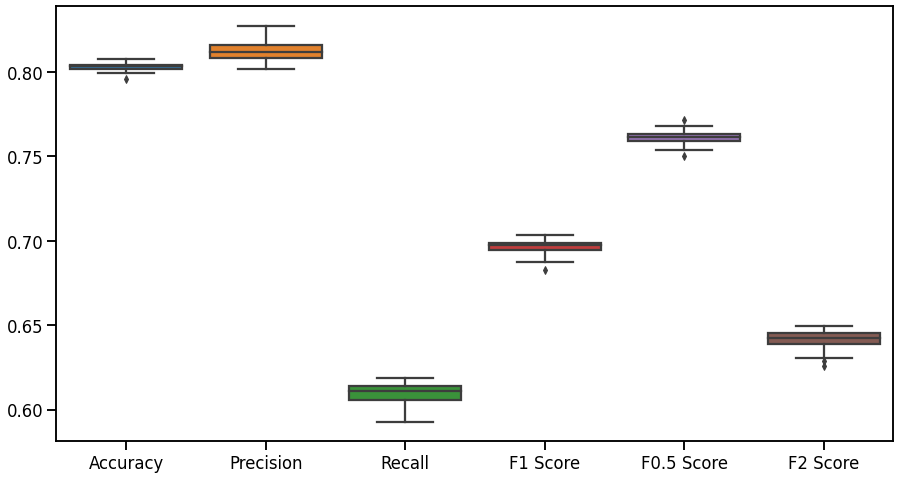

In [62]:
# graficamos las metricas de los 50 arboles

all_metrics = accs + precisions + recalls + f1s + f05s + f2s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s) +  ['F0.5 Score']*len(f05s)+ ['F2 Score']*len(f2s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [63]:
max(recalls)

0.6185698134539288

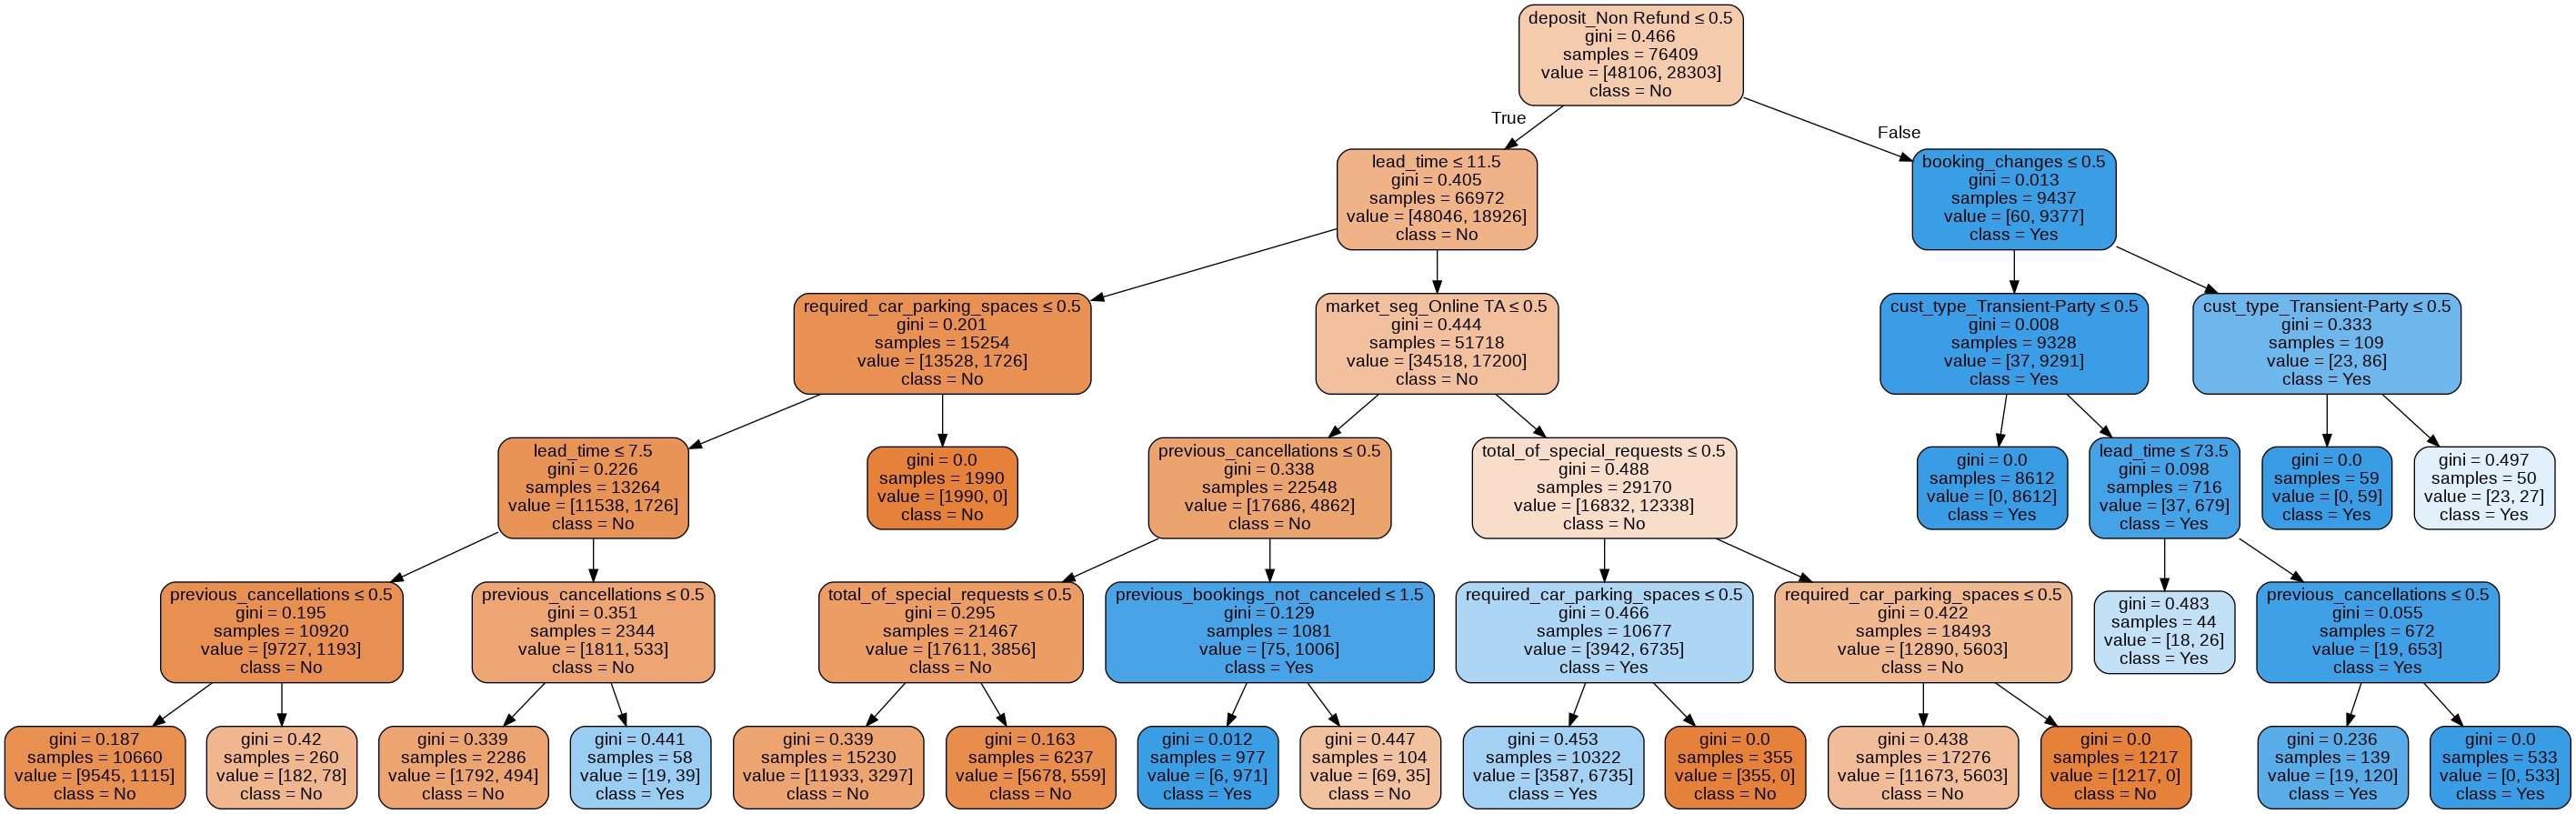

In [64]:
# graficamos el ultimo arbol generado con las 50 semillas

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol_sklearn, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['No', 'Yes'],feature_names=list(df_booking[features].columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [65]:
# vemos los atritbutos mas importantes ordenados por importancia
a = pd.DataFrame(arbol_sklearn.feature_importances_, df_booking[features].columns)
a.columns=["importancia"]

# solo muestro con valor mayor a cero
a[a.importancia>0].sort_values(by="importancia", ascending=False)


importancia
deposit_Non Refund                 0.590749
total_of_special_requests          0.112814
previous_cancellations             0.085319
lead_time                          0.084766
market_seg_Online TA               0.077231
required_car_parking_spaces        0.041672
previous_bookings_not_canceled     0.005737
cust_type_Transient-Party          0.001058
booking_changes                    0.000652

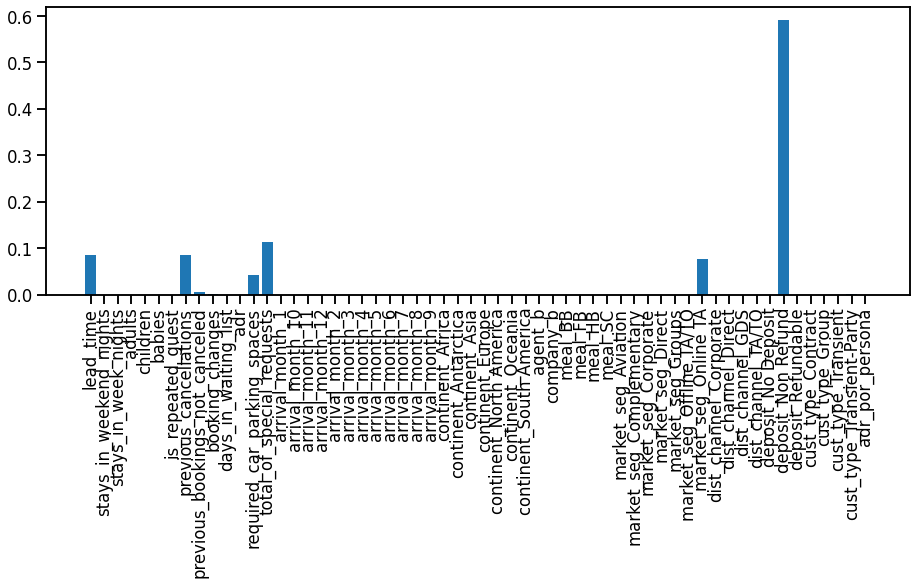

In [66]:
# grafico de importance featurs
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(features,arbol_sklearn.feature_importances_)
plt.xticks(features, rotation = 90)
plt.show()

In [67]:
# g) 2.
# armamos de nuevo el arbol con 50 folds de cross validation y variando con los hiperparametros
# sin poda
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,10)),
               'ccp_alpha':[0.0],
               'min_samples_leaf':list(range(1,21))}

kfoldcv = StratifiedKFold(n_splits=50)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(recall_score)
randomcv2 = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,
                               scoring=scorer_fn,cv=kfoldcv,n_iter=50,random_state=48)
randomcv2.fit(x_develop,y_develop)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=50, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
                                                    splitter='best'),
    

In [68]:
# vemos los resultados del proceso
cv_results2 =pd.DataFrame(randomcv2.cv_results_)
cv_results2.sort_values(by=['mean_test_score'], ascending=False).head(3)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
14       0.574021      0.019764  ...        0.018552                1
0        0.613719      0.022376  ...        0.017930                2
32       0.608593      0.013915  ...        0.017955                3

[3 rows x 62 columns]

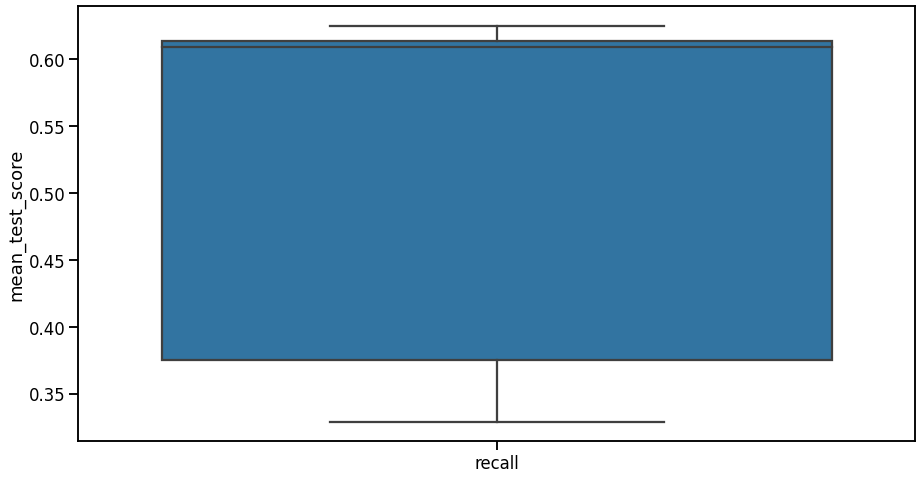

In [69]:
# grafico de boxplot con las 50 mediciones 
all_metrics=cv_results2['mean_test_score']

metric_labels= ['recall']*len(cv_results2['mean_test_score'] )

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [70]:
# h
# buscamos los parametros del mejor arbol
randomcv2.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 16}

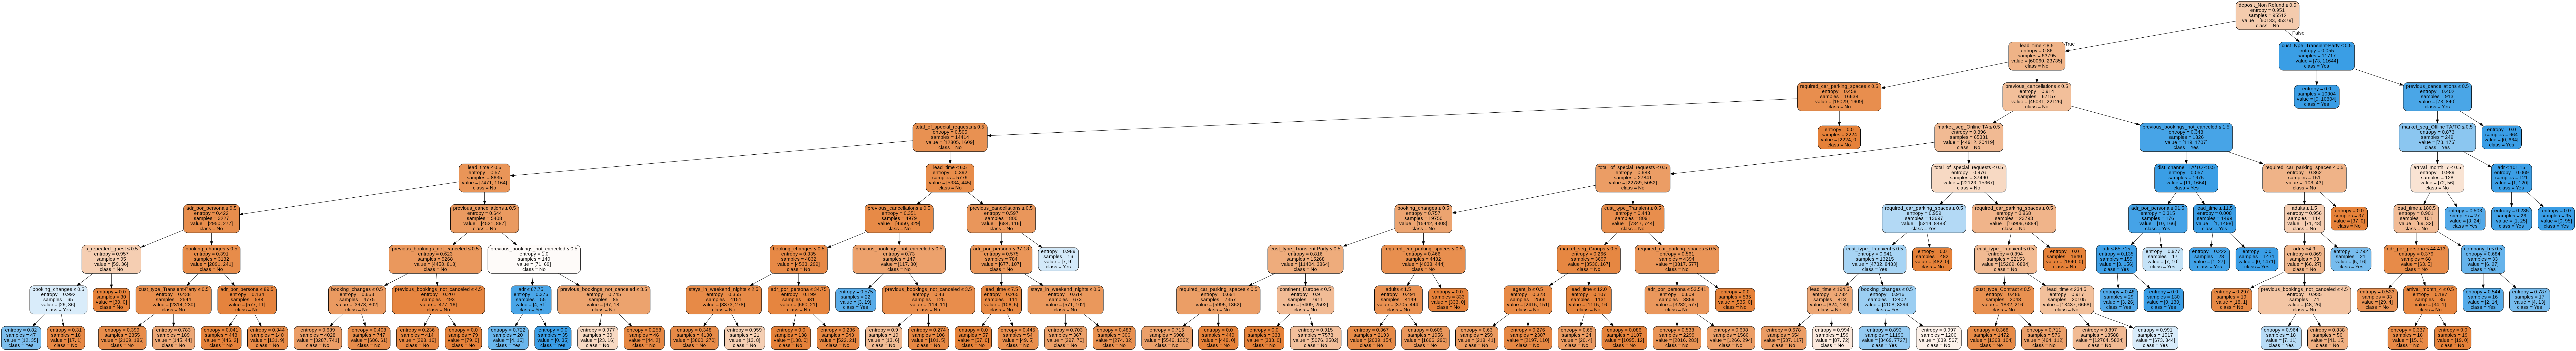

In [71]:
# h

# graficamos el mejor arbol
arbol_sklearn2 = randomcv2.best_estimator_

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol_sklearn2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['No', 'Yes'],
                feature_names=list(df_booking[features].columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [72]:
# vemos los atributos mas importantes del mejor arbol
a = pd.DataFrame(arbol_sklearn2.feature_importances_, df_booking[features].columns)
a.columns=["importancia"]

a[a.importancia>0].sort_values(by="importancia", ascending=False)


importancia
deposit_Non Refund                 0.502878
lead_time                          0.096590
total_of_special_requests          0.094537
market_seg_Online TA               0.080752
previous_cancellations             0.068580
required_car_parking_spaces        0.061388
cust_type_Transient                0.026515
booking_changes                    0.018347
previous_bookings_not_canceled     0.016559
cust_type_Transient-Party          0.015344
continent_Europe                   0.005198
adr_por_persona                    0.003191
market_seg_Offline TA/TO           0.002285
adults                             0.001647
cust_type_Contract                 0.001219
market_seg_Groups                  0.000887
dist_channel_TA/TO                 0.000782
agent_b                            0.000760
is_repeated_guest                  0.000734
adr                                0.000610
arrival_month_7                    0.000609
stays_in_weekend_nights            0.000544
arrival_month_4                    0.000032
company_b                          0.000014

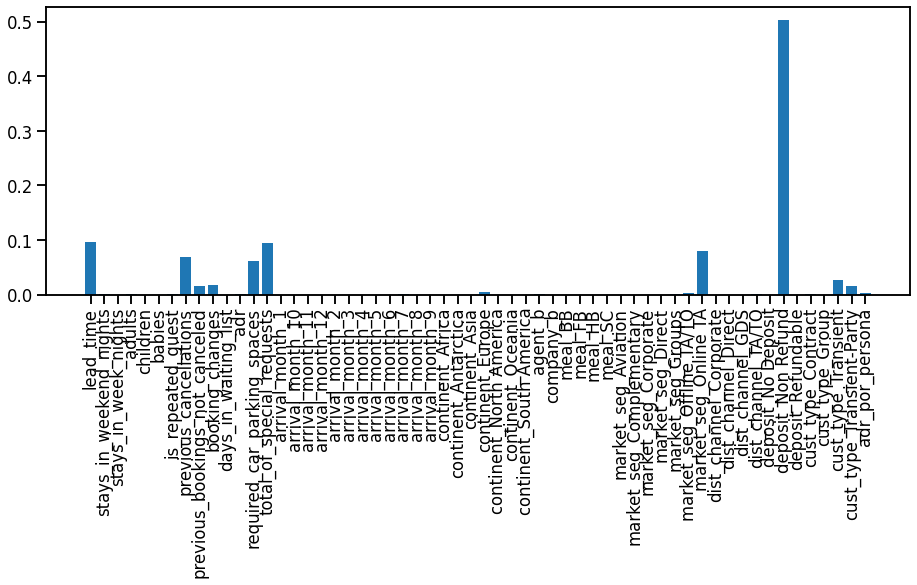

In [73]:
# grafico de importance features
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(features,arbol_sklearn2.feature_importances_)
plt.xticks(features, rotation = 90)
plt.show()

In [74]:
# i)
# tomando el mejor arbol del punto anterior
# le variamos la poda y analizamos

from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from array import array

# armo los hiperparametros fijos con los valores del mejor arbol
crit=[]
crit.append(arbol_sklearn2.criterion)

depth=[]
depth.append(arbol_sklearn2.max_depth)

min_sam=[]
min_sam.append(arbol_sklearn2.min_samples_leaf)

params_grid = {'criterion':crit,
               'max_depth':depth,
               'ccp_alpha':np.linspace(0,0.5,100),
               'min_samples_leaf':min_sam}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(recall_score)
randomcv3 = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,
                               scoring=scorer_fn,cv=kfoldcv,n_iter=10,random_state=48)
randomcv3.fit(x_develop,y_develop)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
       0.4040404 , 0.40909091, 0.41414141, 0.41919192, 0.42424242,
       

In [75]:
# buscamos los paramtros del mejor arbol
randomcv3.best_params_

{'ccp_alpha': 0.025252525252525256,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 16}

In [76]:
pd.DataFrame(randomcv3.cv_results_).head()

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.511622      0.007841  ...        0.000000                5
1       0.513780      0.009027  ...        0.013139                1
2       0.521190      0.014679  ...        0.000000                5
3       0.544974      0.013185  ...        0.010248                2
4       0.539395      0.009493  ...        0.010248                2

[5 rows x 22 columns]

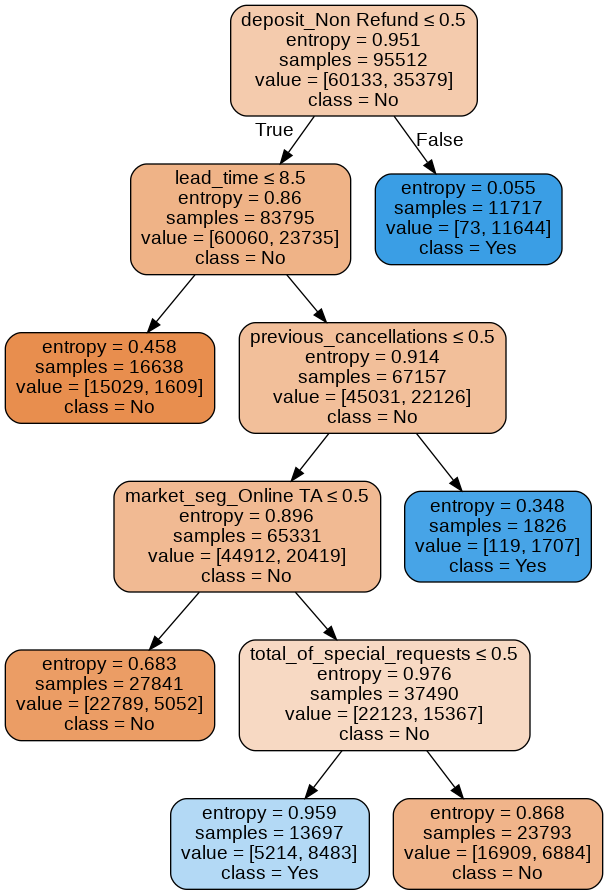

In [77]:
# graficamos el mejor arbol
arbol_sklearn3= randomcv3.best_estimator_

dot_data = StringIO()
export_graphviz(arbol_sklearn3, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['No', 'Yes'],feature_names=list(df_booking[features].columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [78]:
# Hacer gráficos de la performance en validación y entrenamiento en función del α

ccp_alphas = pd.DataFrame(randomcv3.cv_results_)['param_ccp_alpha'].sort_values()
clfs = []
recalls2 = []
fbeta2score2=[]

recalls3 = []
fbeta2score3=[]

for x in ccp_alphas:
  # aplico los mejores parametros del arbol generado con poda
  # y variamos el alpha con los que fueron usados en el RandomizedSearchCV
  x_train_, x_val, y_train_, y_val = train_test_split(x_develop, y_develop, test_size=0.2, stratify=y_develop)

  clf= DecisionTreeClassifier(criterion=arbol_sklearn3.criterion, max_depth=arbol_sklearn3.max_depth,
                              min_samples_leaf=arbol_sklearn3.min_samples_leaf, ccp_alpha=x,
                              random_state=42)
  
  clf.fit(x_train_,y_train_)

  y_pred_val_t = arbol_sklearn.predict(x_val)
  y_pred_train_t = arbol_sklearn.predict(x_train_)

  recalls2.append(recall_score(y_val,y_pred_val_t))
  fbeta2score2.append(fbeta_score(y_val,y_pred_val_t, beta=2))

  recalls3.append(recall_score(y_train_,y_pred_train_t))
  fbeta2score3.append(fbeta_score(y_train_,y_pred_train_t, beta=2))

  clfs.append(clf)
  

<Figure size 432x288 with 0 Axes>

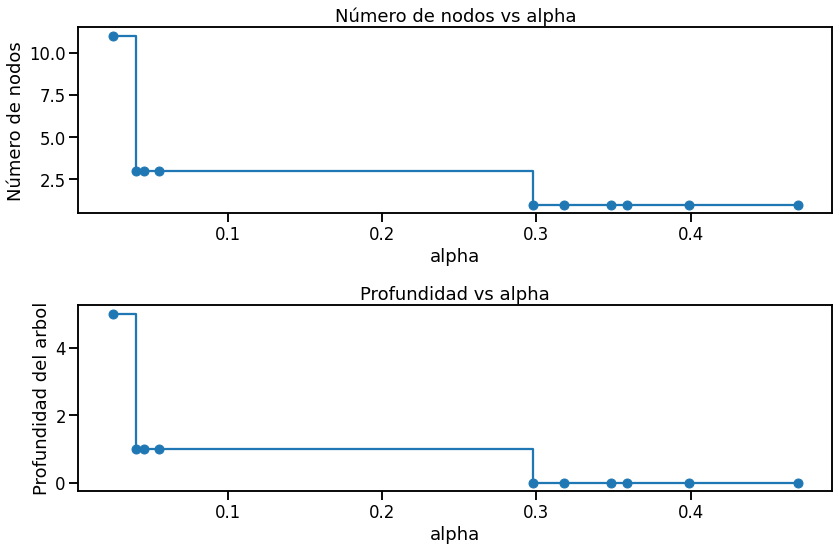

In [79]:
# comparamos la profundidad de los nodos y el nro de nodos vs los valores de alpha
# en el arbol con poda
clfs = clfs
ccp_alphas = ccp_alphas

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.figure(1)
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12,8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Número de nodos")
ax[0].set_title("Número de nodos vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Profundidad del arbol")
ax[1].set_title("Profundidad vs alpha")

fig.tight_layout()
plt.show()

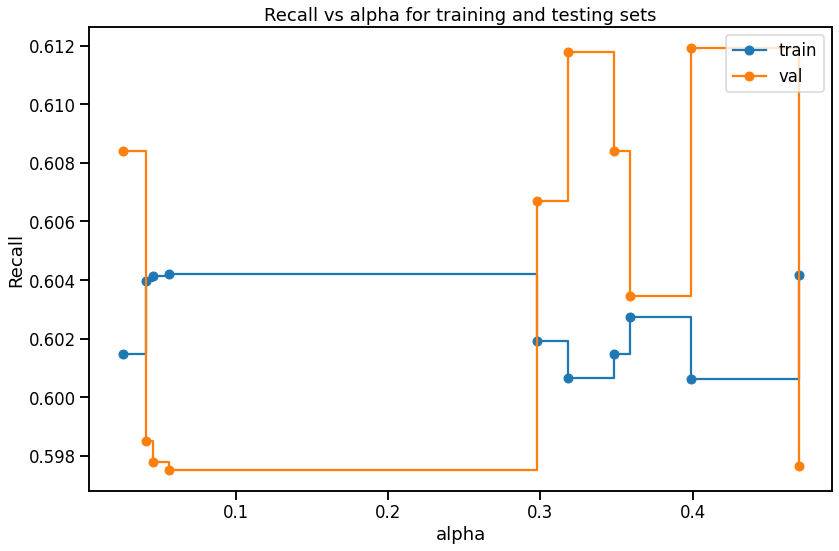

In [80]:
#comparamos la profundidad de los arboles y el nro de nodos vs los valores de alpha
val_scores = recalls2
train_scores = recalls3

fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="val",
        drawstyle="steps-post")
ax.legend()

fig.tight_layout()
plt.show()

F2 score de arbol SIN poda en Test 0.649
Recall de arbol SIN poda en Test 0.614


Text(19.5, 0.5, 'Test')

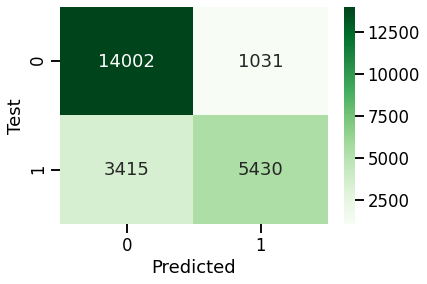

In [81]:
# j)
# Evaluar en el conjunto de evaluación, el árbol correspondiente 
# al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)
from sklearn.metrics import  confusion_matrix, classification_report

# Hacemos la prediccion en test para arbol sin poda
y_pred_val_s_poda = arbol_sklearn2.predict(x_test)

print("F2 score de arbol SIN poda en Test {}".format(round(fbeta_score(y_test,y_pred_val_s_poda, beta=2),3))) 
print("Recall de arbol SIN poda en Test {}".format(round(recall_score(y_test,y_pred_val_s_poda),3))) 
cm_s_poda= confusion_matrix(y_test,y_pred_val_s_poda)

sns.heatmap(cm_s_poda, cmap='Greens',annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Test')

F2 score de arbol CON poda en Test 0.642
Recall de arbol CON poda en Test 0.612


Text(19.5, 0.5, 'Test')

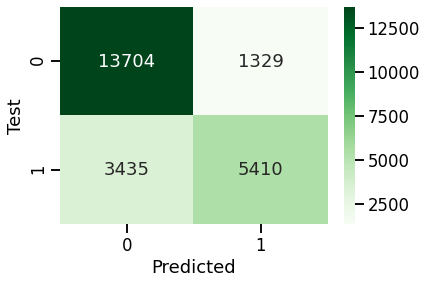

In [82]:

from sklearn.metrics import  confusion_matrix, classification_report

# Hacemos la prediccion en test para arbol con poda
y_pred_val_c_poda = arbol_sklearn3.predict(x_test)

print("F2 score de arbol CON poda en Test {}".format(round(fbeta_score(y_test,y_pred_val_c_poda, beta=2),3)))
print("Recall de arbol CON poda en Test {}".format(round(recall_score(y_test,y_pred_val_c_poda),3))) 
cm_c_poda=  confusion_matrix(y_test,y_pred_val_c_poda)

sns.heatmap(cm_c_poda, cmap='Greens',annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Test')



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


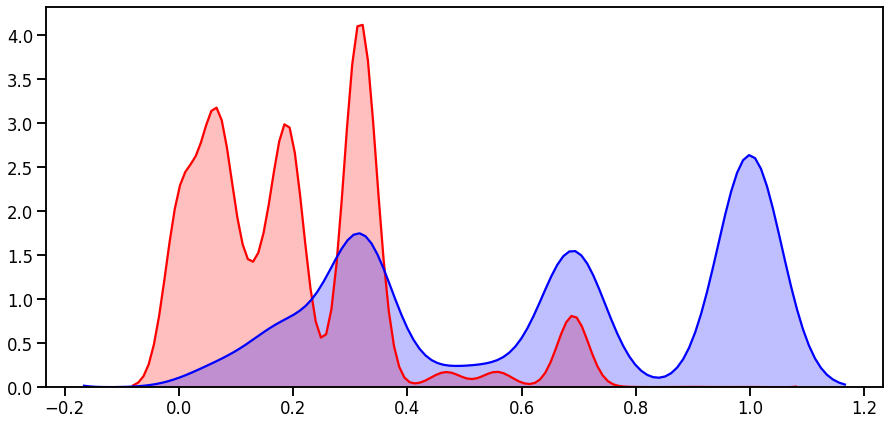

In [83]:
# seguimos comparando ambos arboles
# comparamos las probabilidades 
# sin poda
y_scores = arbol_sklearn2.predict_proba(x_test)
out_probs_2 = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs_2[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs_2[y_test==1],shade=True,c='b')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


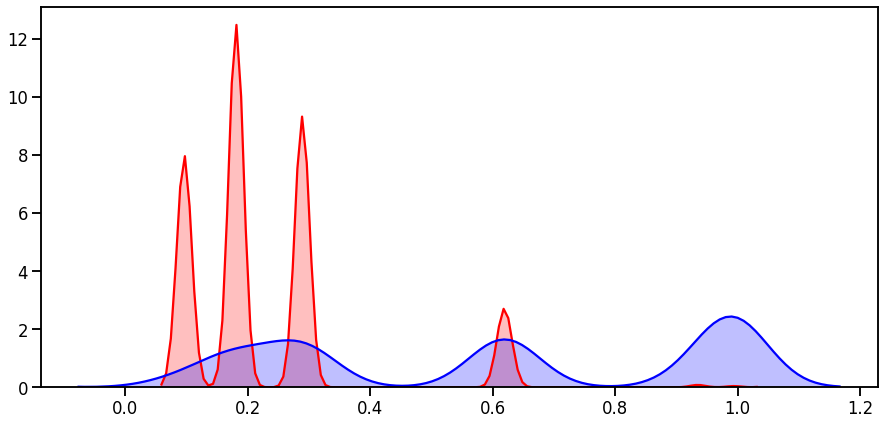

In [84]:
# con poda
y_scores = arbol_sklearn3.predict_proba(x_test)
out_probs_3 = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs_3[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs_3[y_test==1],shade=True,c='b')

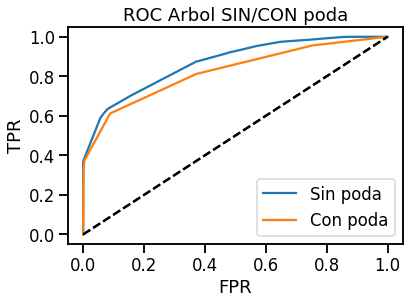

In [85]:
# curva roc arbol,sin poda
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.metrics import roc_auc_score

fpr,tpr,th = roc_curve(y_test,out_probs_2)

fpr3,tpr3,th3 = roc_curve(y_test,out_probs_3)

plt.title('ROC Arbol SIN/CON poda')
plt.plot(fpr,tpr, label='Sin poda')
plt.plot(fpr3,tpr3, label='Con poda')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,fpr,'--k')
plt.plot(fpr3,fpr3,'--k')
plt.legend()
plt.show()


In [86]:
# k) la técnica de eliminación recursiva para el arbol sin poda
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

from sklearn.feature_selection import RFE

selector = RFE(estimator=arbol_sklearn2, n_features_to_select=3, step=1)
selector = selector.fit(x_train, y_train)

selector.support_


array([ True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False])

In [87]:
selector.ranking_

array([ 1, 20, 26, 12, 25, 24, 15,  4,  7,  6, 31, 13,  1,  2, 39, 42, 44,
       46, 48, 51, 49, 53, 55, 19, 28, 32, 34, 36, 56,  9, 47, 45, 43, 18,
       21, 27, 38, 40, 22, 30, 33, 35, 50, 16, 11,  3, 54, 52, 37, 17, 41,
        1, 29, 14, 23,  5,  8, 10])

In [88]:
# toma los ultimos 3 atributos xq son los mejor rankeados
df_booking[features].columns[selector.support_]


Index(['lead_time', 'required_car_parking_spaces', 'deposit_Non Refund'], dtype='object')

In [89]:
# tomamos solo los 3 atributos y los probamos con el arbol sin poda
cols=(selector.ranking_==1)

x_train_2= x_develop[:,cols]
x_test_2 = x_test[:,cols]

# reentrenamos el arbol sin poda 
arbol_sklearn4=arbol_sklearn2
arbol_sklearn4.fit(x_train_2,y_develop)

# lo aplicamos sobre test
y_pred_test_2 = arbol_sklearn4.predict(x_test_2)



Recall: 0.336
Accuracy: 0.751
Precision: 0.972
F2 score: 0.387


Text(19.5, 0.5, 'Test')

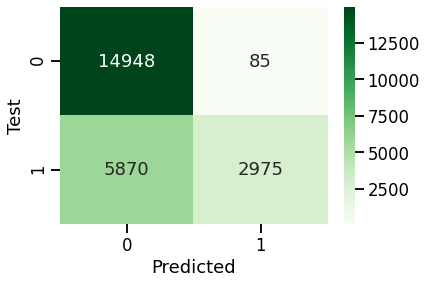

In [90]:
print('Recall: {}'.format(round(recall_score(y_test,y_pred_test_2),3)))
print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred_test_2),3)))
print('Precision: {}'.format(round(precision_score(y_test,y_pred_test_2),3)))
print('F2 score: {}'.format(round(fbeta_score(y_test,y_pred_test_2, beta=2),3)))

cm_c_poda=  confusion_matrix(y_test,y_pred_test_2)

sns.heatmap(cm_c_poda, cmap='Greens',annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Test')


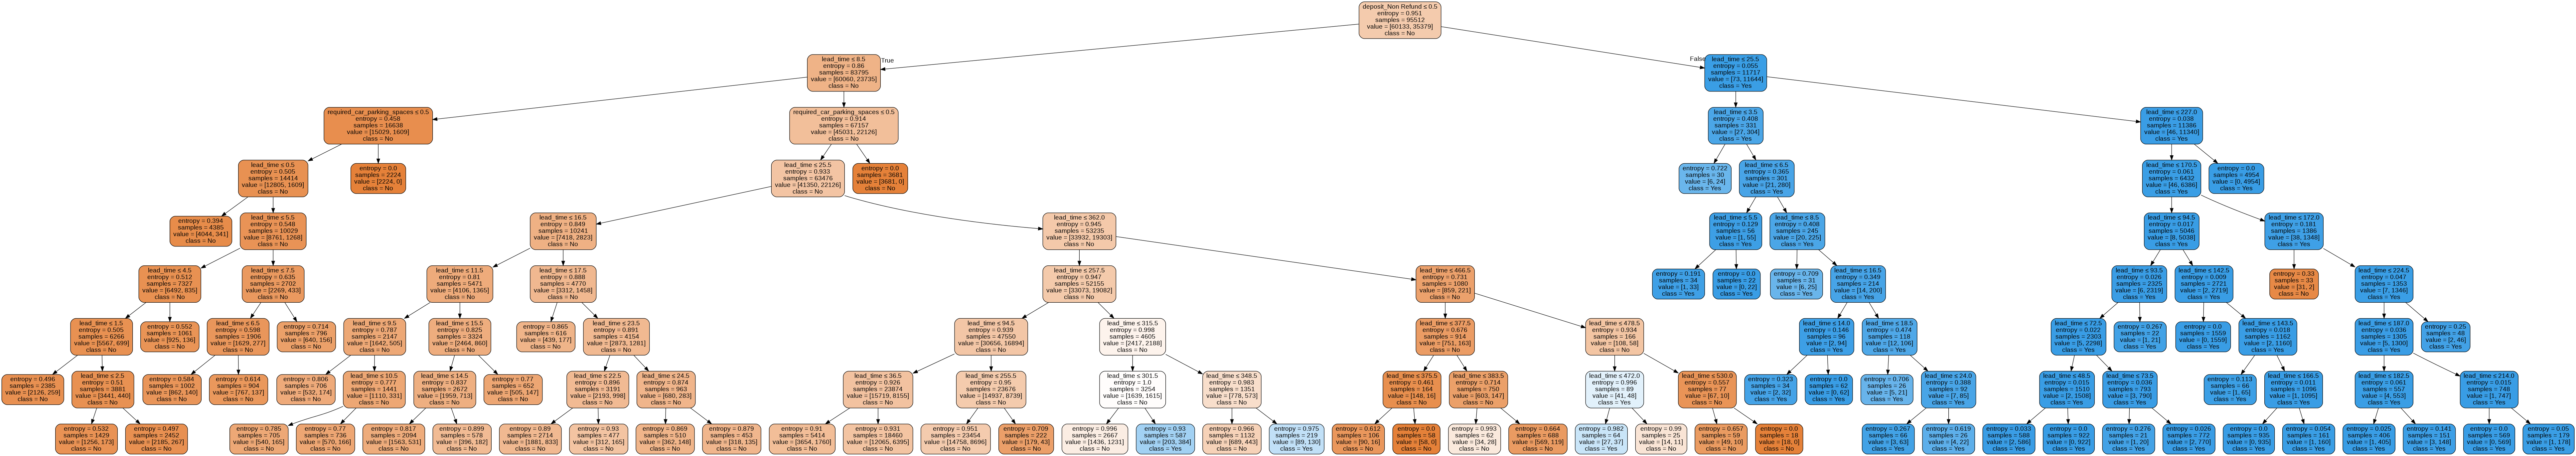

In [91]:

dot_data = StringIO()
export_graphviz(arbol_sklearn4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['No', 'Yes'],
                feature_names=list(df_booking[features].columns[selector.support_]))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
